### Exact Inference
#### In this notebook lets construct a bayesian model and do exact inference using variable elimination and belief propagation.

In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
%matplotlib inline

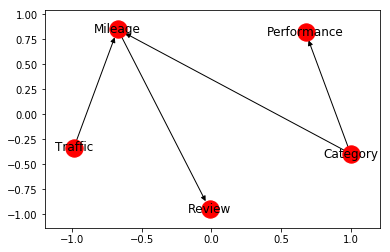

In [2]:
# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('Traffic', 'Mileage'), ('Category', 'Mileage'), ('Mileage', 'Review'),
                       ('Category', 'Performance')])
nx.draw_networkx(model)

#### Now let us create the Conditional probability distributions for each of the variables introduced.

In [3]:
cpd_t = TabularCPD(variable='Traffic', variable_card=2, values=[[0.6, 0.4]])
cpd_c = TabularCPD(variable='Category', variable_card=2, values=[[0.7, 0.3]])

In [4]:
cpd_m = TabularCPD(variable='Mileage', variable_card=3, 
                   values=[[0.2, 0.05, 0.9,  0.3],
                           [0.6, 0.25, 0.08, 0.5],
                           [0.2, 0.7,  0.02, 0.2]],
                  evidence=['Category', 'Traffic'],
                  evidence_card=[2, 2])

In [5]:
cpd_r = TabularCPD(variable='Review', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['Mileage'],
                   evidence_card=[3])

In [6]:
cpd_p = TabularCPD(variable='Performance', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['Category'],
                   evidence_card=[2])

In [7]:
model.add_cpds(cpd_t, cpd_c, cpd_m, cpd_r, cpd_p)

In [8]:
print(model.get_cpds('Mileage'))

+-----------+------------+------------+------------+------------+
| Category  | Category_0 | Category_0 | Category_1 | Category_1 |
+-----------+------------+------------+------------+------------+
| Traffic   | Traffic_0  | Traffic_1  | Traffic_0  | Traffic_1  |
+-----------+------------+------------+------------+------------+
| Mileage_0 | 0.2        | 0.05       | 0.9        | 0.3        |
+-----------+------------+------------+------------+------------+
| Mileage_1 | 0.6        | 0.25       | 0.08       | 0.5        |
+-----------+------------+------------+------------+------------+
| Mileage_2 | 0.2        | 0.7        | 0.02       | 0.2        |
+-----------+------------+------------+------------+------------+


### Inference using Variable Elimination
#### Having constructed a model, now the process of inference is making queries about the variables in the model. In this demo we use variable elimination method.

In [9]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [10]:
# To find the marginal distribution of  a variable , we need to construct a query as below.
from pgmpy.factors.discrete import DiscreteFactor
print(infer.query(['Mileage']))

+-----------+----------------+
| Mileage   |   phi(Mileage) |
+===========+================+
| Mileage_0 |         0.2960 |
+-----------+----------------+
| Mileage_1 |         0.3964 |
+-----------+----------------+
| Mileage_2 |         0.3076 |
+-----------+----------------+


In [11]:
print(infer.query(['Traffic']))

+-----------+----------------+
| Traffic   |   phi(Traffic) |
+===========+================+
| Traffic_0 |         0.6000 |
+-----------+----------------+
| Traffic_1 |         0.4000 |
+-----------+----------------+


#### In above case we infer that the traffic is high with probability 0.4 and low with probability 0.6.

### Conditional queries

#### We can also fix values for some variables and then query the model for another variable of interest. Let us fix the traffic to be low(T_O) and the car to be a sports car.

In [12]:
print(infer.query(['Mileage'],evidence={'Traffic': 0, 'Category': 1}))

+-----------+----------------+
| Mileage   |   phi(Mileage) |
+===========+================+
| Mileage_0 |         0.9000 |
+-----------+----------------+
| Mileage_1 |         0.0800 |
+-----------+----------------+
| Mileage_2 |         0.0200 |
+-----------+----------------+


#### We could see that the probability of mileage being high(M_0) increases now compared with the marginal distribution.

### Inference using Belief Propagation:
#### Once the model is constructed different inference methods can be used to make queries. Let us use belief propagation to make queries.

In [13]:
from pgmpy.inference import BeliefPropagation

In [14]:
infer = BeliefPropagation(model)

In [15]:
print(infer.query(['Mileage'],evidence={'Traffic': 0, 'Category': 1}))

+-----------+----------------+
| Mileage   |   phi(Mileage) |
+===========+================+
| Mileage_0 |         0.5400 |
+-----------+----------------+
| Mileage_1 |         0.0480 |
+-----------+----------------+
| Mileage_2 |         0.0120 |
+-----------+----------------+


#### Let us change the traffic to be high (T_1) and compare its influence on mileage

In [16]:
print(infer.query(['Mileage'],evidence={'Traffic': 1, 'Category': 1}))

+-----------+----------------+
| Mileage   |   phi(Mileage) |
+===========+================+
| Mileage_0 |         0.1200 |
+-----------+----------------+
| Mileage_1 |         0.2000 |
+-----------+----------------+
| Mileage_2 |         0.0800 |
+-----------+----------------+


### MAP queries
#### MAP queries return the most probable values a variable might take.
#### We can see now the probability of high mileage(M_0)goes down and the probability of medium mileage(M_1) goes up

In [17]:
infer.map_query(variables=['Mileage'])

{'Mileage': 1}

#### If the traffic is high and we are travelling in a sports car, let us query for the review of the car. Evidence variables needs to be passed as a dictionary.

In [18]:
infer.map_query(variables=['Review'],evidence={'Traffic':1,'Category':1})

{'Review': 1}

#### Let us change the car to commuter car and see if it impacts the review

In [19]:
infer.map_query(variables=['Review'],evidence={'Traffic':1,'Category':0})

{'Review': 0}